In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import roc_auc_score, roc_curve, auc
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import warnings, gc
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [48]:
train = pd.read_pickle("C:/Users/sony6/OneDrive/바탕 화면/AMEX_PICKLE/train_agg.pkl", compression="gzip")
test = pd.read_pickle("C:/Users/sony6/OneDrive/바탕 화면/AMEX_PICKLE/test_agg.pkl", compression="gzip")

In [12]:
train.head()

,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,...,D_64_count,D_64_last,D_64_nunique,D_66_count,D_66_last,D_66_nunique,D_68_count,D_68_last,D_68_nunique,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.933594,0.024194,0.868652,0.960449,0.934570,0.010704,0.024440,0.001082,0.091492,0.009117,...,13,1,1,0,2,0,13,6,1,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.899902,0.022097,0.861328,0.929199,0.880371,0.215210,0.199123,0.002224,0.567383,0.178101,...,13,1,1,0,2,0,13,6,1,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.878418,0.028837,0.797852,0.904297,0.880859,0.004181,0.002759,0.000802,0.009705,0.009705,...,13,2,1,0,2,0,13,6,1,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.599121,0.020082,0.567383,0.623535,0.621582,0.048859,0.088490,0.000660,0.268555,0.001082,...,13,1,1,0,2,0,13,3,3,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.891602,0.042316,0.805176,0.940430,0.872070,0.004642,0.002883,0.000030,0.008682,0.005573,...,13,1,1,13,1,1,13,6,1,0


In [13]:
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x == 0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()

    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x == 0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

In [14]:
features = test.columns.to_list()
cat_features = [
    "B_30",
    "B_38",
    "D_114",
    "D_116",
    "D_117",
    "D_120",
    "D_126",
    "D_63",
    "D_64",
    "D_66",
    "D_68"
]
cat_features = [f"{cf}_last" for cf in cat_features]
le_encoder = LabelEncoder()
for categorical_feature in cat_features:
    train[categorical_feature] = le_encoder.fit_transform(train[categorical_feature])
    test[categorical_feature] = le_encoder.transform(test[categorical_feature])

In [15]:
train_y = pd.DataFrame(train["target"])
train_x = train.drop("target", axis=1)

In [16]:
N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=22)
y_oof = np.zeros(train_x.shape[0])
y_test = np.zeros(test.shape[0])
ix = 0
for train_ind, val_ind in skf.split(train_x, train_y):
    print(f"******* Fold {ix} ******* ")
    tr_x, val_x = (
        train_x.iloc[train_ind].reset_index(drop=True),
        train_x.iloc[val_ind].reset_index(drop=True),
    )
    tr_y, val_y = (
        train_y.iloc[train_ind].reset_index(drop=True),
        train_y.iloc[val_ind].reset_index(drop=True),
    )

    clf = CatBoostClassifier(iterations=5000, random_state=22)
    clf.fit(tr_x, tr_y, eval_set=[(val_x, val_y)], cat_features=cat_features,  verbose=100)
    preds = clf.predict_proba(val_x)[:, 1]
    y_oof[val_ind] = y_oof[val_ind] + preds

    preds_test = clf.predict_proba(test)[:, 1]
    y_test = y_test + preds_test / N_FOLDS
    ix = ix + 1
y_pred = train_y.copy(deep=True)
y_pred = y_pred.rename(columns={"target": "prediction"})
y_pred["prediction"] = y_oof
val_score = amex_metric(train_y, y_pred)
print(f"Amex metric: {val_score}")

******* Fold 0 ******* 
Learning rate set to 0.067666
0:	learn: 0.6119352	test: 0.6120468	best: 0.6120468 (0)	total: 242ms	remaining: 20m 11s
100:	learn: 0.2273057	test: 0.2310528	best: 0.2310528 (100)	total: 28.4s	remaining: 22m 57s
200:	learn: 0.2202569	test: 0.2257175	best: 0.2257175 (200)	total: 1m 5s	remaining: 26m 3s
300:	learn: 0.2154637	test: 0.2234274	best: 0.2234274 (300)	total: 1m 43s	remaining: 27m 2s
400:	learn: 0.2117488	test: 0.2223236	best: 0.2223236 (400)	total: 2m 24s	remaining: 27m 42s
500:	learn: 0.2084733	test: 0.2216831	best: 0.2216829 (499)	total: 2m 55s	remaining: 26m 13s
600:	learn: 0.2053916	test: 0.2213167	best: 0.2213167 (600)	total: 3m 25s	remaining: 25m 1s
700:	learn: 0.2025058	test: 0.2210150	best: 0.2210150 (700)	total: 3m 54s	remaining: 24m
800:	learn: 0.1997851	test: 0.2208520	best: 0.2208520 (800)	total: 4m 31s	remaining: 23m 43s
900:	learn: 0.1970921	test: 0.2207752	best: 0.2207625 (872)	total: 5m 9s	remaining: 23m 28s
1000:	learn: 0.1945829	test: 0.

In [17]:
y_oof_binary = (y_oof >= np.percentile(y_oof, 96)).astype(int)

In [18]:
y_oof_binary.mean()

0.040001045949885926

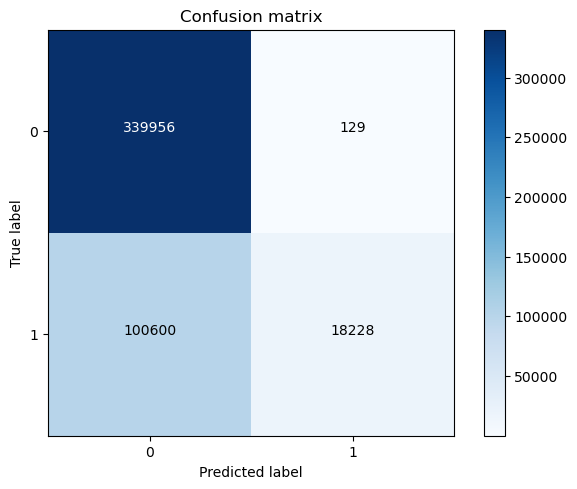

In [21]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm = confusion_matrix(train_y, y_oof_binary)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm,
                      classes = class_names,
                      title = f'Confusion matrix')
plt.show()

## new

In [ ]:
features = test.columns.to_list()
cat_features = [
    "B_30",
    "B_38",
    "D_114",
    "D_116",
    "D_117",
    "D_120",
    "D_126",
    "D_63",
    "D_64",
    "D_66",
    "D_68"
]
cat_features = [f"{cf}_last" for cf in cat_features]
le_encoder = LabelEncoder()
for categorical_feature in cat_features:
    train[categorical_feature] = le_encoder.fit_transform(train[categorical_feature])
    test[categorical_feature] = le_encoder.transform(test[categorical_feature])

******* Fold 0 ******* 
Learning rate set to 0.067666
0:	learn: 0.6119352	test: 0.6120468	best: 0.6120468 (0)	total: 309ms	remaining: 25m 43s
100:	learn: 0.2273057	test: 0.2310528	best: 0.2310528 (100)	total: 34.8s	remaining: 28m 6s
200:	learn: 0.2202569	test: 0.2257175	best: 0.2257175 (200)	total: 1m 9s	remaining: 27m 29s
300:	learn: 0.2154637	test: 0.2234274	best: 0.2234274 (300)	total: 1m 43s	remaining: 26m 58s
400:	learn: 0.2117488	test: 0.2223236	best: 0.2223236 (400)	total: 2m 18s	remaining: 26m 26s
500:	learn: 0.2084733	test: 0.2216831	best: 0.2216829 (499)	total: 2m 52s	remaining: 25m 51s
600:	learn: 0.2053916	test: 0.2213167	best: 0.2213167 (600)	total: 3m 27s	remaining: 25m 19s
700:	learn: 0.2025058	test: 0.2210150	best: 0.2210150 (700)	total: 4m 5s	remaining: 25m 8s
800:	learn: 0.1997851	test: 0.2208520	best: 0.2208520 (800)	total: 4m 40s	remaining: 24m 31s
900:	learn: 0.1970921	test: 0.2207752	best: 0.2207625 (872)	total: 5m 16s	remaining: 24m
1000:	learn: 0.1945829	test: 0

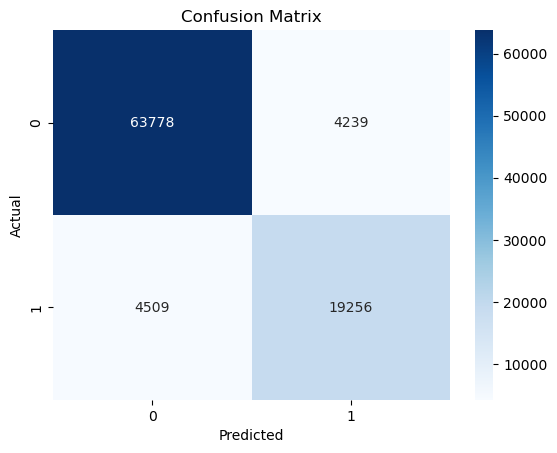

Accuracy: 0.9046871935673662
F1 Score: 0.814896318239526
Precision: 0.8195786337518621
Recall: 0.8102671996633705
Specificity: 0.93767734536954


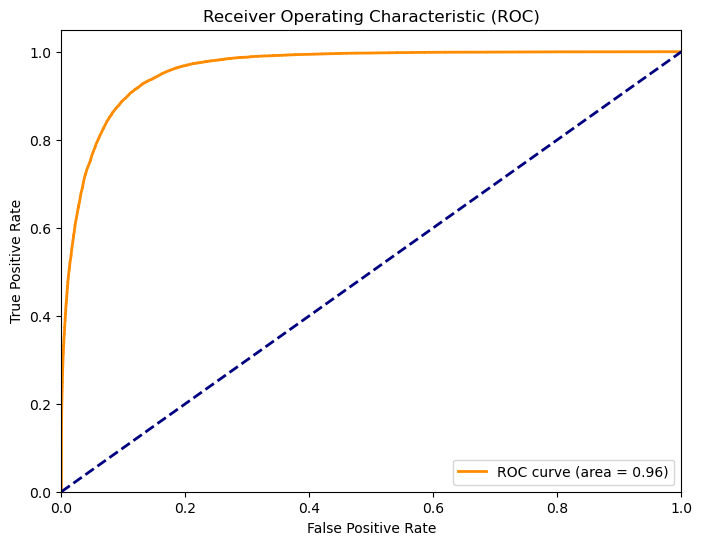

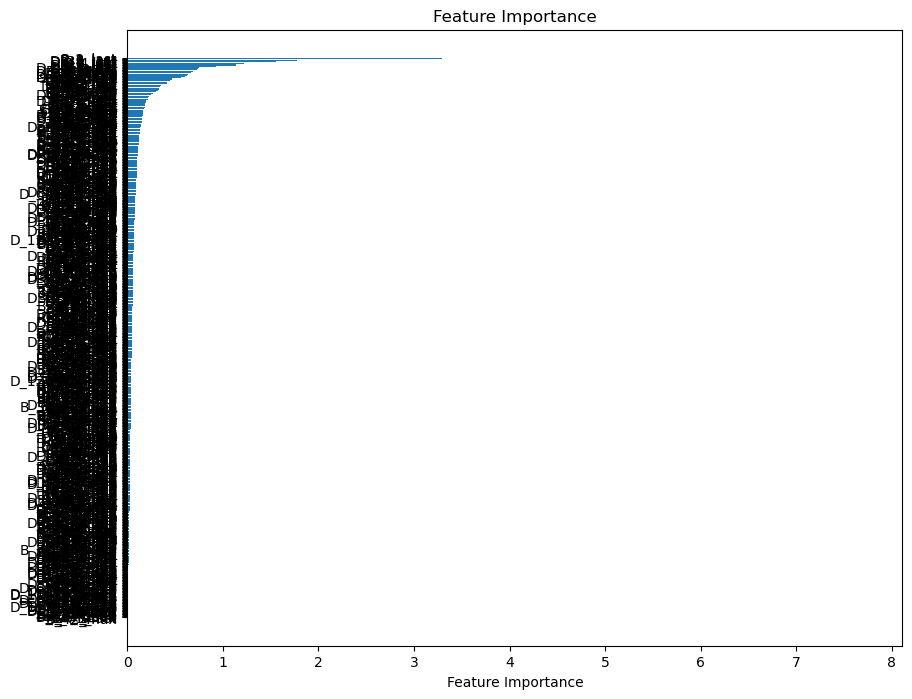

In [55]:
import catboost
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
train = pd.read_pickle("C:/Users/sony6/OneDrive/바탕 화면/AMEX_PICKLE/train_agg.pkl", compression="gzip")
test = pd.read_pickle("C:/Users/sony6/OneDrive/바탕 화면/AMEX_PICKLE/test_agg.pkl", compression="gzip")

def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x == 0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()

    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x == 0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

features = test.columns.to_list()
cat_features = [
    "B_30",
    "B_38",
    "D_114",
    "D_116",
    "D_117",
    "D_120",
    "D_126",
    "D_63",
    "D_64",
    "D_66",
    "D_68"
]
cat_features = [f"{cf}_last" for cf in cat_features]
le_encoder = LabelEncoder()
for categorical_feature in cat_features:
    train[categorical_feature] = le_encoder.fit_transform(train[categorical_feature])
    test[categorical_feature] = le_encoder.transform(test[categorical_feature])
train_y = pd.DataFrame(train["target"])
train_x = train.drop("target", axis=1)

N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=22)
y_oof = np.zeros(train_x.shape[0])
y_test = np.zeros(test.shape[0])
ix = 0
for train_ind, val_ind in skf.split(train_x, train_y):
    print(f"******* Fold {ix} ******* ")
    tr_x, val_x = (
        train_x.iloc[train_ind].reset_index(drop=True),
        train_x.iloc[val_ind].reset_index(drop=True),
    )
    tr_y, val_y = (
        train_y.iloc[train_ind].reset_index(drop=True),
        train_y.iloc[val_ind].reset_index(drop=True),
    )

    clf = CatBoostClassifier(iterations=5000, random_state=22)
    clf.fit(tr_x, tr_y, eval_set=[(val_x, val_y)], cat_features=cat_features,  verbose=100)
    preds = clf.predict_proba(val_x)[:, 1]
    y_oof[val_ind] = y_oof[val_ind] + preds

    preds_test = clf.predict_proba(test)[:, 1]
    y_test = y_test + preds_test / N_FOLDS
    ix = ix + 1
y_pred = train_y.copy(deep=True)
y_pred = y_pred.rename(columns={"target": "prediction"})
y_pred["prediction"] = y_oof
val_score = amex_metric(train_y, y_pred)
print(f"Amex metric: {val_score}")

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Confusion Matrix 계산
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# ROC Curve 및 AUC 계산 및 시각화
def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

# Accuracy, F1 Score, Sensitivity, Specificity 계산
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    
    return accuracy, f1, precision, recall, specificity

# Feature Importance 시각화
def plot_feature_importance(model, feature_names):
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)

    plt.figure(figsize=(10, 8))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance')
    plt.show()

# 예측 및 성과 지표 계산
y_pred_prob = clf.predict_proba(val_x)[:, 1]
y_pred = (y_pred_prob > 0.5).astype(int)

# Confusion Matrix 시각화
plot_confusion_matrix(val_y, y_pred)

# Accuracy, F1 Score, Precision, Recall, Specificity 계산
accuracy, f1, precision, recall, specificity = calculate_metrics(val_y, y_pred)
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Specificity: {specificity}')

# ROC Curve 및 AUC 시각화
plot_roc_curve(val_y, y_pred_prob)

# Feature Importance 시각화
plot_feature_importance(clf, train_x.columns)

In [43]:
X

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,NaN,NaN,...,NaN,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674
1,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,NaN,NaN,...,NaN,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216
2,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,NaN,NaN,...,NaN,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604
3,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,NaN,NaN,...,NaN,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598
4,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,NaN,NaN,...,NaN,NaN,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531446,0.979492,0.416016,0.020813,0.828125,0.003487,0.090759,0.005341,0.025146,NaN,0.014229,...,NaN,NaN,NaN,0.006836,0.003679,0.000457,NaN,0.000906,0.001497,0.002775
5531447,0.984863,0.296631,0.007210,0.812500,0.005905,0.079895,0.002243,0.023697,NaN,0.009468,...,NaN,NaN,NaN,0.003309,0.007095,0.007858,NaN,0.002777,0.008224,0.008858
5531448,0.982910,0.444092,0.013153,0.815430,0.003456,0.100525,0.002111,0.012344,NaN,0.006592,...,NaN,NaN,NaN,0.009956,0.009995,0.001088,NaN,0.005692,0.006775,0.005566
5531449,0.969727,0.442627,0.009857,1.003906,0.005116,0.101807,0.009933,0.008575,NaN,0.014236,...,NaN,NaN,NaN,0.005543,0.006565,0.009880,NaN,0.008125,0.001168,0.003983


In [44]:
y

0          0
1          0
2          0
3          0
4          0
          ..
5531446    0
5531447    0
5531448    0
5531449    0
5531450    0
Name: target, Length: 5531451, dtype: int64

In [31]:
train = pd.read_feather('C:/Users/sony6/OneDrive/바탕 화면/AMEX_FTR/train_data.ftr')
train

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,NaN,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531446,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-11-05,0.979492,0.416016,0.020813,0.828125,0.003487,0.090759,0.005341,0.025146,...,NaN,NaN,0.006836,0.003679,0.000457,NaN,0.000906,0.001497,0.002775,0
5531447,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-12-23,0.984863,0.296631,0.007210,0.812500,0.005905,0.079895,0.002243,0.023697,...,NaN,NaN,0.003309,0.007095,0.007858,NaN,0.002777,0.008224,0.008858,0
5531448,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-01-06,0.982910,0.444092,0.013153,0.815430,0.003456,0.100525,0.002111,0.012344,...,NaN,NaN,0.009956,0.009995,0.001088,NaN,0.005692,0.006775,0.005566,0
5531449,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-02-06,0.969727,0.442627,0.009857,1.003906,0.005116,0.101807,0.009933,0.008575,...,NaN,NaN,0.005543,0.006565,0.009880,NaN,0.008125,0.001168,0.003983,0


## end

In [22]:
test["prediction"] = y_test
test["prediction"].to_csv(f"C:/Users/sony6/OneDrive/바탕 화면/AMEX_PICKLE/submission_cat_{val_score}.csv", index=True)

In [2]:
cat = pd.read_csv('C:/Users/sony6/OneDrive/바탕 화면/AMEX_RESULT/catboost_submission.csv')
extra = pd.read_csv('C:/Users/sony6/OneDrive/바탕 화면/AMEX_RESULT/ExtraTree_submission.csv')
lgbm = pd.read_csv('C:/Users/sony6/OneDrive/바탕 화면/AMEX_RESULT/LGBM_submission.csv')

In [3]:
cat

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.020893
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.001682
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.040849
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.231456
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.865958
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,0.010299
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,0.779499
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,0.441166
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,0.294070


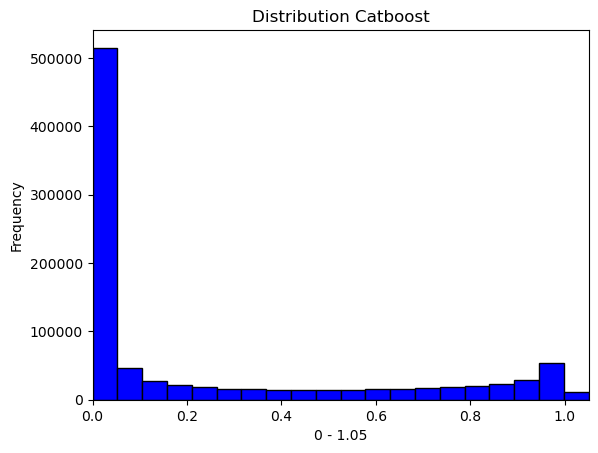

In [9]:
import matplotlib.pyplot as plt

# 데이터프레임을 가져오고, 분포를 확인하려는 열을 선택합니다.
# 예를 들어, 'column_name'은 분포를 확인하려는 열의 이름입니다.
# 'df'는 데이터프레임 객체입니다.
# 아래 예제에서는 데이터프레임을 생성하여 사용하도록 합니다.
import pandas as pd
import numpy as np

# 예제 데이터프레임 생성
data = cat
df = pd.DataFrame(data)

# 히스토그램 생성
plt.hist(df['prediction'], bins=20, range=(0, 1.05), color='blue', edgecolor='black')

# 그래프 제목과 라벨 추가
plt.title('Distribution Catboost')
plt.xlabel('0 - 1.05')
plt.ylabel('Frequency')

# x축 범위 설정
plt.xlim(0, 1.05)

# 그래프 출력
plt.show()

In [4]:
extra

,Unnamed: 0,customer_ID,prediction
0,0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0
1,1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0
2,2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0
3,3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0
4,4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0
...,...,...,...
199995,199995,3764bc8412d6f3a3316f239620121c28f721dc4e5cef44...,0
199996,199996,3764d984f88196f8bde70b32fd7369d1ea546324281b68...,0
199997,199997,3764f1d98cf43ada3795baae51f5097c21fed6eba6c8df...,0
199998,199998,37650a4275d62c34c6ef0a5a644ef951f33d1a6e040e55...,0


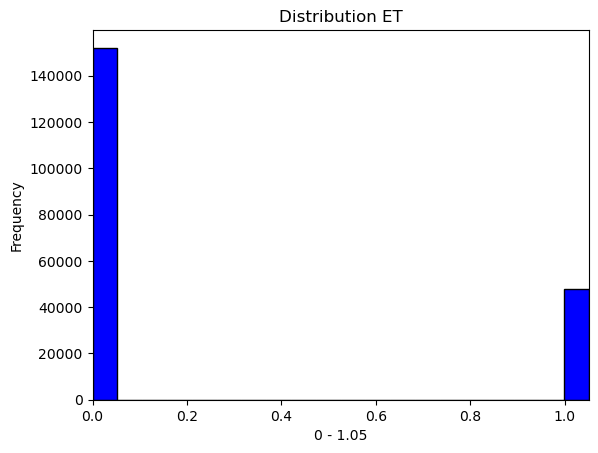

In [11]:
data = extra
df = pd.DataFrame(data)

# 히스토그램 생성
plt.hist(df['prediction'], bins=20, range=(0, 1.05), color='blue', edgecolor='black')

# 그래프 제목과 라벨 추가
plt.title('Distribution ET')
plt.xlabel('0 - 1.05')
plt.ylabel('Frequency')

# x축 범위 설정
plt.xlim(0, 1.05)

# 그래프 출력
plt.show()

In [5]:
lgbm

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.025870
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.001676
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.031351
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.285678
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.902863
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,0.016621
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,0.747242
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,0.472885
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,0.268209


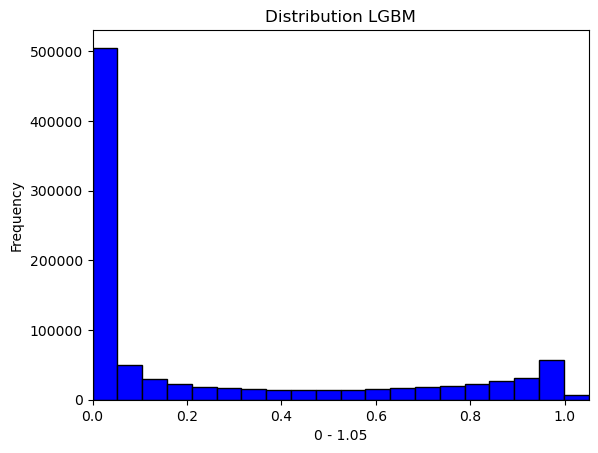

In [13]:
data = lgbm
df = pd.DataFrame(data)

# 히스토그램 생성
plt.hist(df['prediction'], bins=20, range=(0, 1.05), color='blue', edgecolor='black')

# 그래프 제목과 라벨 추가
plt.title('Distribution LGBM')
plt.xlabel('0 - 1.05')
plt.ylabel('Frequency')

# x축 범위 설정
plt.xlim(0, 1.05)

# 그래프 출력
plt.show()

In [29]:
pip install openpyxl

     ---------------------------------------- 0.0/250.0 kB ? eta -:--:--
     ------- ------------------------------- 51.2/250.0 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 250.0/250.0 kB 5.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [46]:
import pandas as pd

# Excel 파일을 읽어오기
a = pd.read_excel("C:/Users/sony6/OneDrive/바탕 화면/TYMICT.xlsx")
a_1 = a.drop('SN', axis=1,)
a_1

,V_HOUR,VUT,EEC1_1,VSPEED,PTOT,DRT,MT,VUDT,TFEF,TFEA,...,EEC3_3,EEC3_4,EEC3_5,IC1_1,AF_RUN,DPF_SOOT,DPF_ASH,UR_SP,T_REGEN,C_REGEN
0,187.55,0,75,0.00,0,0,0,0,0.03,4.37,...,254,130,140.19,94,0,0,0,0.0,694544,0
1,187.55,0,28,0.00,0,0,0,1,0.08,3.69,...,18,130,135.40,100,0,0,0,0.0,694604,0
2,187.55,0,24,0.00,0,0,0,2,0.13,3.40,...,15,130,135.19,100,0,0,0,0.0,694664,0
3,187.60,0,22,0.00,0,0,0,3,0.18,3.17,...,14,130,135.00,100,0,0,0,0.0,694724,0
4,187.60,0,20,0.00,0,0,0,4,0.22,2.99,...,13,130,136.19,100,0,0,0,0.0,694784,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3079,345.35,56,16,0.00,0,0,13,24,1.16,2.87,...,8,130,70.40,80,0,0,0,0.0,1262996,0
3080,345.35,56,19,0.57,0,0,13,25,1.19,2.83,...,25,130,96.59,78,0,0,0,0.0,1263056,0
3081,345.39,56,22,2.06,0,0,14,26,1.23,2.81,...,40,130,154.40,78,0,0,0,0.0,1263116,0
3082,345.39,56,21,1.63,0,0,14,27,1.27,2.80,...,43,130,180.60,78,0,0,0,0.0,1263177,0


In [47]:
a_1.dtypes

V_HOUR      float64
VUT           int64
EEC1_1        int64
VSPEED      float64
PTOT          int64
DRT           int64
MT            int64
VUDT          int64
TFEF        float64
TFEA        float64
PTOD          int64
DRD           int64
DIS         float64
PTOA          int64
DRA           int64
TARE          int64
LOCA         object
WSPEED      float64
EEC2_3        int64
E_RPM       float64
ET1_1         int64
ET1_2       float64
EFLP1_1       int64
EFLP1_2       int64
VEP_1       float64
AMB_2       float64
UR_LV       float64
UR_TMP        int64
EEC2_1        int64
EEC2_2      float64
EEC2_4      float64
IC1_2         int64
IC1_3       float64
IC1_4       float64
EEC3_1        int64
EEC3_2      float64
EEC3_3        int64
EEC3_4        int64
EEC3_5      float64
IC1_1         int64
AF_RUN        int64
DPF_SOOT      int64
DPF_ASH       int64
UR_SP       float64
T_REGEN       int64
C_REGEN       int64
dtype: object

In [51]:
numeric_columns = a_1.select_dtypes(include=['int', 'float'])
numeric_columns

,V_HOUR,VUT,EEC1_1,VSPEED,PTOT,DRT,MT,VUDT,TFEF,TFEA,...,EEC3_3,EEC3_4,EEC3_5,IC1_1,AF_RUN,DPF_SOOT,DPF_ASH,UR_SP,T_REGEN,C_REGEN
0,187.55,0,75,0.00,0,0,0,0,0.03,4.37,...,254,130,140.19,94,0,0,0,0.0,694544,0
1,187.55,0,28,0.00,0,0,0,1,0.08,3.69,...,18,130,135.40,100,0,0,0,0.0,694604,0
2,187.55,0,24,0.00,0,0,0,2,0.13,3.40,...,15,130,135.19,100,0,0,0,0.0,694664,0
3,187.60,0,22,0.00,0,0,0,3,0.18,3.17,...,14,130,135.00,100,0,0,0,0.0,694724,0
4,187.60,0,20,0.00,0,0,0,4,0.22,2.99,...,13,130,136.19,100,0,0,0,0.0,694784,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3079,345.35,56,16,0.00,0,0,13,24,1.16,2.87,...,8,130,70.40,80,0,0,0,0.0,1262996,0
3080,345.35,56,19,0.57,0,0,13,25,1.19,2.83,...,25,130,96.59,78,0,0,0,0.0,1263056,0
3081,345.39,56,22,2.06,0,0,14,26,1.23,2.81,...,40,130,154.40,78,0,0,0,0.0,1263116,0
3082,345.39,56,21,1.63,0,0,14,27,1.27,2.80,...,43,130,180.60,78,0,0,0,0.0,1263177,0


In [58]:

corr=numeric_columns.corr()
corr=corr['V_HOUR'].sort_values(ascending=False)[1:-1]
pal = sns.color_palette("Reds_r", 135).as_hex()
rgb = ['rgba' + str(matplotlib.colors.to_rgba(i, 0.7)) for i in pal]
fig = go.Figure()
fig.add_trace(go.Bar(x=corr[corr >= 0], y=corr[corr >= 0].index,
                     marker_color=rgb, orientation='h',
                     marker_line=dict(color=pal, width=2), name='',
                     hovertemplate='%{y} correlation with target: %{x:.3f}',
                     showlegend=False))
pal = sns.color_palette("Blues", 100).as_hex()
rgb = ['rgba' + str(matplotlib.colors.to_rgba(i, 0.7)) for i in pal]
fig.add_trace(go.Bar(x=corr[corr < 0], y=corr[corr < 0].index,
                     marker_color=rgb[25:], orientation='h',
                     marker_line=dict(color=pal[25:], width=2), name='',
                     hovertemplate='%{y} correlation with target: %{x:.3f}',
                     showlegend=False))

fig.update_layout(title="Feature Correlations with V_HOUR",
                  xaxis_title="Correlation", margin=dict(l=150),
                  height=3000, width=700, hovermode='closest')
fig.show()

In [ ]:
corr=train.corr()
corr=corr['Target'].sort_values(ascending=False)[1:-1]
pal=sns.color_palette("Reds_r",135).as_hex()
rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.7)) for i in pal]
fig = go.Figure()
fig.add_trace(go.Bar(x=corr[corr>=0], y=corr[corr>=0].index, 
                     marker_color=rgb, orientation='h', 
                     marker_line=dict(color=pal,width=2), name='',
                     hovertemplate='%{y} correlation with target: %{x:.3f}',
                     showlegend=False))
pal=sns.color_palette("Blues",100).as_hex()
rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.7)) for i in pal]
fig.add_trace(go.Bar(x=corr[corr<0], y=corr[corr<0].index, 
                     marker_color=rgb[25:], orientation='h', 
                     marker_line=dict(color=pal[25:],width=2), name='',
                     hovertemplate='%{y} correlation with target: %{x:.3f}',
                     showlegend=False))
fig.update_layout(template=temp,title="Feature Correlations with Target",
                  xaxis_title="Correlation", margin=dict(l=150),
                  height=3000, width=700, hovermode='closest')
fig.show()